In [2]:
import os
import pandas as pd
import numpy as np
import chromadb
from chromadb.utils import embedding_functions
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import top_k_accuracy_score
from typing import List
import warnings
import skops.io as sio
from sentence_transformers import SentenceTransformer

Read in data, split into training and test sets, and create ONET-to-Name dictionary.

In [3]:
df = pd.read_csv('data.csv')
ONET_TO_NAME = pd.Series(df['ONET_NAME'].values, index=df['ONET']).to_dict()

# By default, the function shuffles the data before splitting it into non-overlapping subsets
train, not_train = train_test_split(df, test_size=0.1, random_state=42)
valid, test = train_test_split(not_train, test_size=0.5, random_state=42)
len(train), len(valid), len(test)

(45000, 2500, 2500)

In [4]:
onet_list = pd.read_csv('2019_Occupations.csv')
onet_list.rename(columns={'O*NET-SOC 2019 Code': 'ONET', 'O*NET-SOC 2019 Title': 'ONET_NAME', 'O*NET-SOC 2019 Description': 'BODY'}, inplace=True)
onet_list['ID'] = onet_list['ONET'].apply(lambda x: 'definition_' + x)

train = pd.concat([train, onet_list])

Create vector database (with chromadb) to store embeddings, with a collection for each partition

In [19]:
client = chromadb.PersistentClient(path='vectordb')
sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2")
train_collection = client.get_collection(name='onet_train', embedding_function=sentence_transformer_ef)
val_collection = client.get_collection(name='onet_val', embedding_function=sentence_transformer_ef)
test_collection = client.get_collection(name='onet_test', embedding_function=sentence_transformer_ef)

This code was used to originally add data to the chroma databases, and generate the embeddings in the process.

```python
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = embedding_model.encode(onet_list['BODY'].tolist(), batch_size=8, show_progress_bar=True)
onet_list['embeddings'] = embeddings.tolist()

for _, row in tqdm(onet_list.iterrows(), total=len(onet_list)):
    train_collection.add(
        ids=row['ID'],
        documents=row['BODY'],
        embeddings=row['embeddings'],
        metadatas= {
            'ONET': row['ONET'],
            'ONET_NAME': row['ONET_NAME'],
        }
    )
```

Retrieve embeddings

In [20]:
train_embeds = train_collection.get(ids=train['ID'].tolist(), include=['embeddings'])
id_to_embed = dict(zip(train_embeds['ids'], train_embeds['embeddings']))
train['embeddings'] = train['ID'].apply(lambda x: id_to_embed[x])

valid_embeds = val_collection.get(ids=valid['ID'].tolist(), include=['embeddings'])
id_to_embed = dict(zip(valid_embeds['ids'], valid_embeds['embeddings']))
valid['embeddings'] = valid['ID'].apply(lambda x: id_to_embed[x])

test_embeds = test_collection.get(ids=test['ID'].tolist(), include=['embeddings'])
id_to_embed = dict(zip(test_embeds['ids'], test_embeds['embeddings']))
test['embeddings'] = test['ID'].apply(lambda x: id_to_embed[x])

In [27]:
X = train['embeddings'].tolist()
y = train['ONET'].tolist()

Determine how many neighbors to consider for each pass of the KNN algorithm

In [35]:
def compute_accs(dfs: List[pd.DataFrame], ks: List[float], seed : int=42) -> List[float]:
    accs = [[] for _ in dfs]
    for k in tqdm(ks):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X, y) 
        for i, df in enumerate(dfs):
            if len(df) > 2500:
                s = df.sample(2500, random_state=seed)
            else:
                s = df
            accs[i].append(model.score(s['embeddings'].tolist(), s['ONET'].tolist()))
    return accs

Best validation accuracy (0.4708) occurs at k=17


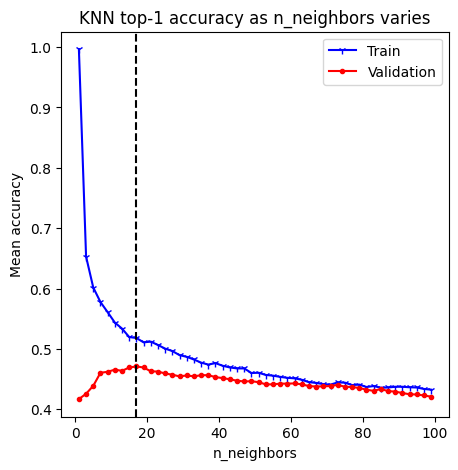

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))

ks = list(range(1, 100, 2))
train_accs = []
val_accs = []
train_accs, val_accs = compute_accs([train, valid], ks) # this takes a while to run!
ax.plot(ks, train_accs, c='b', marker='1')
ax.plot(ks, val_accs, c='r', marker='.')
best_k = ks[np.argmax(val_accs)]
ax.axvline(best_k, c='k', linestyle='--', )
ax.set_xlabel('n_neighbors')
ax.set_ylabel('Mean accuracy')
ax.legend(['Train', 'Validation'])
ax.set_title('KNN top-1 accuracy as n_neighbors varies')
print(f"Best validation accuracy ({max(val_accs)}) occurs at k={best_k}")
plt.show()

Select the model with the best validation accuracy

In [36]:
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(X, y)
sio.dump(model, 'knn.skops') # save model to disk

Compare top-N accuracy as N varies - we expect this to increase monotonically

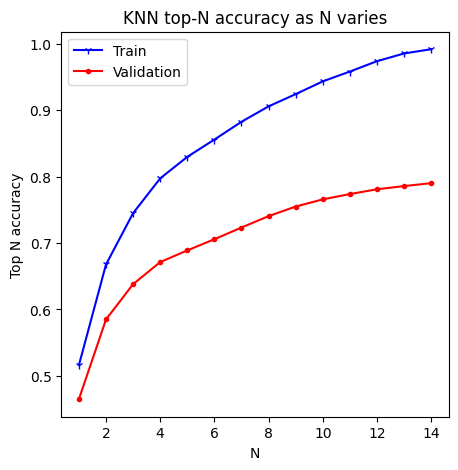

In [40]:
fig, ax = plt.subplots(figsize=(5, 5))
train_subset = train.sample(n=2500, random_state=42)
train_preds = model.predict_proba(train_subset['embeddings'].tolist())
val_preds = model.predict_proba(valid['embeddings'].tolist())
Ns = list(range(1, 15))
train_acc = []
val_acc = []
for N in Ns:
    train_acc.append(top_k_accuracy_score(
        y_true=train_subset['ONET'].tolist(), 
        y_score=train_preds, 
        k=N, 
        labels=model.classes_
    ))
    val_acc.append(top_k_accuracy_score(
        y_true=valid['ONET'].tolist(), 
        y_score=val_preds, 
        k=N, 
        labels=model.classes_
    ))
ax.plot(Ns, train_acc, c='b', marker='1')
ax.plot(Ns, val_acc, c='r', marker='.')
ax.set_xlabel('N')
ax.set_ylabel('Top N accuracy')
ax.set_title('KNN top-N accuracy as N varies')
ax.legend(['Train', 'Validation'])
plt.show()

In [43]:
model = sio.load('knn.skops', trusted=True) # Load model from disk

def predict(posting : str, 
            n : int, 
            model : KNeighborsClassifier = model, 
            as_name : bool=False, 
            allow_retrain=False) -> List[str]:
    """Predicts the top n ONETs for a given posting.

    Args:
        posting (str or embedding): The full job posting, as a string.
        n (int): The number of ONETs to return.
        as_name (bool, optional): Whether to return the ONET name or code. Defaults to False.

    Returns:
        List[str]: The top n ONETs.
    """
    # TODO: refactor to allow batched predictions
    model = model
    if n > model.n_neighbors and allow_retrain:
        model = KNeighborsClassifier(n_neighbors=n + 10)
        model.fit(X, y)
        class_labels = np.array(sorted(df['ONET'].unique().tolist()))
        model.classes_ = class_labels
    elif n > model.n_neighbors:
        warnings.warn(f"n={n} is greater than the number of neighbors considered by the model ({model.n_neighbors})." +
                      f" Only {model.n_neighbors} of the results will be meaningful." +
                      f" Allow retraining by setting allow_retrain=True.")
    if isinstance(posting, str):
        embed = np.array(sentence_transformer_ef([posting])[0]).reshape(1, -1)
    elif isinstance(posting, np.ndarray) or (isinstance(posting, list) and isinstance(posting[0], float)):
        embed = np.array(posting).reshape(1, -1)
    else:
        if isinstance(posting, list):
            raise NotImplementedError("Batched predictions are not yet supported.")
        raise NotImplementedError(f"Posting must be a string or an embedding, not {type(posting)}")
    probs = model.predict_proba(embed)
    indices = np.argpartition(probs[0], -n, axis=-1)[-n:]
    pred_onets = reversed(model.classes_[indices]) # reverse to get most likely first
    if as_name:
        return [ONET_TO_NAME[onet] for onet in pred_onets]
    return pred_onets

In [88]:
postings = valid.sample(n=5)
postings, embeddings, true_onets = postings['BODY'].tolist(), postings['embeddings'].tolist(), postings['ONET'].tolist()
for i, posting in enumerate(postings):
    print("Posting body:\n\t", posting.strip().replace('\n', '\t'))
    print(f"Predicted ONETs:\n\t{predict(posting, n=5, as_name=True)}")
    print(f"True ONETs:\n\t{ONET_TO_NAME[true_onets[i]]}\n")

Posting body:
	 Health Bar Attendant	Health Bar Attendant	Hourly Wage 	ISS offers full-time employees a variety of benefits including medical, dental, life and disability insurance, as well as a comprehensive leave program based on employment status. The hourly pay range for this position is $16.50 - $17.00. 	Work Hours 	The work hours for this position are Monday-Friday 6:30 am - 3:00 pm. 	Key Purpose 	Maintain the salad bar area and coffee stations while keeping service areas clean and stocked with product. Merchandise products in an attractive manner to Guckenheimer standard. Greet guests, making them feel welcome. 	Success Criteria 	Arrive on time to all shifts 	Proper uniform; non-slip shoes, name tag 	Professional appearance 	Provide outstanding hospitality 	Don't be afraid to ask for help! 	Key Areas of Collaboration and Influence 	A strong commitment to guest experience 	Always remember safety first. 	Build respectful relationships with all teammates and guests. 	Willingness to

### Deprecated code

In [107]:
# def predictions(postings, n):
#     if isinstance(postings, str):
#         postings = [postings]
#     query_results = train_collection.query(query_texts=postings, n_results=n, include=["metadatas", "distances"])
#     results = []
#     for i, posting in enumerate(postings):
#         doc_ids = query_results['ids'][i]
#         onet_names = [x['ONET_NAME'] for x in query_results['metadatas'][i]]
#         dists = query_results['distances'][i]
#         result = tuple(zip(doc_ids, onet_names, dists))
#         results.append(result)
#     return results

# def predict(posting, n, k_results_per_query=10):
#     predictions = []
#     for i in range(n):
#         if predictions:
#             conditions = {
#                     "ONET_NAME": {"$nin": predictions}
#                 }
#         else:
#             conditions = dict()
#         query_results = train_collection.query(
#                 query_texts=posting, 
#                 n_results=k_results_per_query, 
#                 include=["metadatas", "distances"],
#                 where=conditions
#         )
#         prediction = Counter([query_results['metadatas'][0][j]['ONET_NAME'] for j in range(k_results_per_query)]).most_common(1)[0][0]
#         predictions.append(prediction)
#     return predictions        

In [143]:
# # This function is obsolete; sklearn's top_k_accuracy_score does the same thing and probably faster

# def coverage(predicted, actual) -> float:
#     """Computes the coverage score, which is the fraction of the true labels that are in the predicted labels.

#     Args:
#         predicted (array-like of shape (n_samples, n_outputs)): The predicted sets of labels for each sample.
#         actual (array-like of shape n_samples): The true label for each sample.

#     Returns:
#         float: The coverage score.
#     """
#     assert len(predicted) == len(actual), "The number of samples in the predicted and actual sets must be equal."
#     valid_predicted = [int(actual[i] in set(pred)) for i, pred in enumerate(predicted)]
#     return sum(valid_predicted) / len(set(actual))

In [193]:
# import numpy as np
# predicted = np.random.randint(0, 833, (100, 10))
# actual = np.random.randint(0, 833, (100,))
# coverage(predicted, actual)

0.010869565217391304

### Need to class imbalances

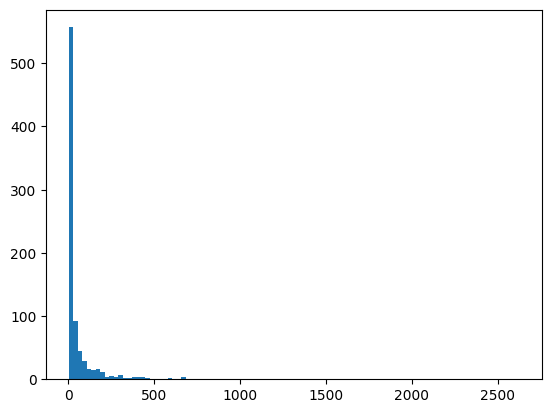

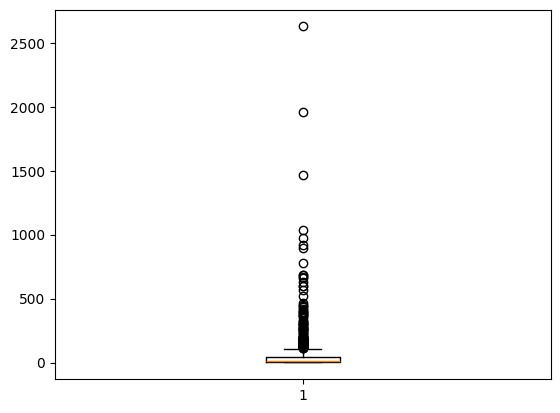

In [198]:
#TODO: Consider class imbalances
import matplotlib.pyplot as plt

plt.hist(df['ONET'].value_counts(), bins=100)
plt.show()
plt.boxplot(df['ONET'].value_counts())
plt.show()

In [97]:
df['ONET_NAME'].value_counts()

ONET_NAME
Registered Nurses                                                                                    2627
Unclassified                                                                                         1956
Retail Salespersons                                                                                  1468
Sales Representatives, Wholesale and Manufacturing, Except Technical and Scientific Products         1037
Software Developers                                                                                   970
                                                                                                     ... 
Slaughterers and Meat Packers                                                                           1
Low Vision Therapists, Orientation and Mobility Specialists, and Vision Rehabilitation Therapists       1
Floor Sanders and Finishers                                                                             1
Brokerage Clerks                    